In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
#import scipy.interpolate as interpolate
#from scipy.stats.mstats import scoreatpercentile
#import scipy.stats as stats
#from scipy.stats import pearsonr
import pandas as pd
import os,subprocess,time,copy
import scipy
import datetime
import matplotlib.gridspec as gridspec
#import pyart.graph.cm as pcm
#import pprint
#import triangle
import corner
import pymc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
print(pymc.__version__)
#import f90nml
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
2023-02-14 12:32:36.096300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 12:32:37.272374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mvanlier/local/OpenBLAS/lib:/usr/lib64/mpich-3.2/lib
2023-02-14 12:32:37.272525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or director

2.11.0
5.0.2


In [5]:
import pytensor
import pytensor.tensor as pt
import pyproj
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level,haversine

In [11]:
import re

In [45]:
#..Get a list of files to read from

case = 'dycoms'
#case = 'bomex'
#case = 'rico'
#case = 'sct'
case_upper = case.upper()

#main_dir = '/home/marcus/marcus_data/E3SM_BOSS_PPE_data/GISS_SCM_PPE/dycoms/'
main_dir = '/data/gelsaess/giss-e3scm-ppe-elsaesser/'+case+'/'
#main_dir = '/Users/marcus/Research/Elsaesser_NASA/SCM_PPE/'+case+'/'
subdir_list = []
num_subdir  = 0
for root,dirs,files in walklevel(main_dir,level=0):
    for dirr in dirs:
        #if dirr.startswith('SCM_'+case_upper+'_jingbo'):
        if dirr.startswith('SCM_'+case_upper+'_gse'):
            subdir_list.append(dirr)
            num_subdir += 1
subdir_list = sorted(subdir_list)
subdir_list = subdir_list[1:]
num_subdir -= 1
print(num_subdir,subdir_list[-1])

850 SCM_DYCOMS_gse850F110


In [46]:
#.. Now let's make a plot or two
idx = 500
#nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(idx+1).zfill(3)+'F110.nc','r')
nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(idx+1).zfill(3)+'F110.nc','r')
time = nc.variables['time'][:]
prec = nc.variables['prec'][:,0,0]
lwp  = nc.variables['lwp'][:,0,0]
nc.close()

## SCM PPE Data load

In [47]:
#..Read in output data
#filenm = '/home/mvanlier/IPythonNBs/E3SM_BOSS_PPE/giss_scm_ppe_dycomsonly_00.txt'
filenm = '/home/mvanlier/IPythonNBs/E3SM_BOSS_PPE/giss_scm_ppe_dycomsonly_01.txt'
out_ens = np.loadtxt(filenm)
print(out_ens.shape)

(850, 5)


In [48]:
numpar = 45
num_ens = 850
nt     = time.shape[0]
allpar = np.zeros((numpar,num_ens))


#..Now do this for all ensemble members
for i in range(num_ens):
    #..Pick one. First see if we can read parameters
    par_dict = {}
    pars = []
    parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                #print(r)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    parnames = parnames + [name]
                idict={name:float(val) for name,val in r}
                par_dict.update(idict)
    allpar[:,i]   = pars

In [49]:
print(allpar.shape)
print(allpar)

(45, 850)
[[7.6406100e+03 2.5055200e+03 1.8910000e+03 ... 7.1970488e+03
  6.8300752e+03 4.6045146e+03]
 [9.3844400e+01 4.7105300e+01 4.0297100e+01 ... 4.1030376e+01
  4.0721077e+01 4.6966305e+01]
 [8.3984900e+01 7.1616800e+01 9.8001800e+01 ... 5.7598038e+01
  4.8630394e+01 1.1990788e+02]
 ...
 [2.8499400e-01 1.3835100e+00 6.8174400e-01 ... 3.1886059e-01
  3.5480505e-01 5.0553751e-01]
 [1.3594500e+00 8.3141700e-01 5.6306700e-01 ... 1.8489029e+00
  1.9006994e+00 1.7016159e+00]
 [1.7610300e+01 1.6804500e+01 1.5925900e+01 ... 1.3762231e+01
  1.6336611e+01 1.5619811e+01]]


In [50]:
out_ens = out_ens.T

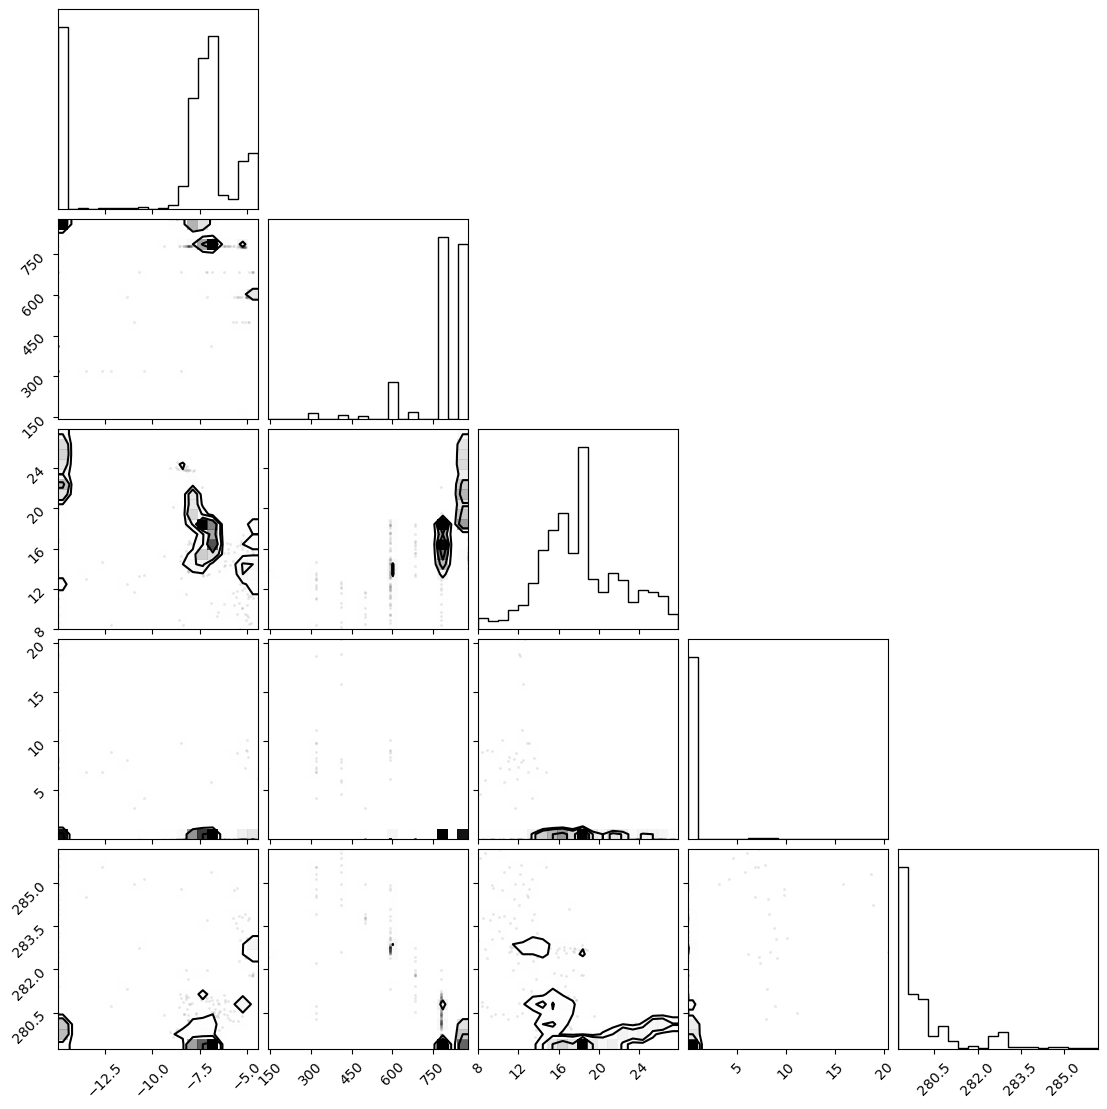

In [78]:
fig = corner.corner(out_ens.T)

In [51]:
par_labs = ['debdecaytime', 'cdnc_ocean_mc', 'cdnc_land_mc_xs', 'dcw_qc', 'qci_detrainment_multiplier', 
            'cloudrvl_mstcnv','cloudrvi_mstcnv', 'bsort_enteff1', 'bsort_enteff2', 'urelscale', 
            'cond_repart_dpscale', 'pthresh_closure2', 'tadjmc1', 'tadjmc2', 'dd_evpeff_qp_scale', 
            'geometric_fevapfac', 'dp_disp_fac', 'dp_disp_max', 'dp_disp2_fac',
            'dp_disp2_max', 'dd_detbyent', 'entcon_dd', 'max_dt_overshoot', 'terminal_aspcp', 'mc_tqstar_fac',
            'mc_fddrt', 'tfmc', 't_homf', 'rhcsl', 'rhctl', 'ni_homfree', 'dcs', 'wb99_rh', 'wact_min', 
            'pf_by_cf', 'invrelvar', 'ac_time', 'scale_cn', 
            'scale_ifn', 'sfluffy', 'vf_mults', 'a_evap_entrain', 'a_sed_entrain']
#out_labs = ['dycoms_prec', 'dycoms_pblht',   'dycoms_tau_ss',       'dycoms_tau_mc', 'dycoms_olr' ]
out_labs = ['dycoms_precclb', 'dycoms_pblht',   'dycoms_tau_ss',       'dycoms_tau_mc', 'dycoms_olr' ]

In [52]:
npar = 45
nobs = 5

In [53]:
#..Divide the ensemble into the training and evaluation datasets
par_lhs = allpar[:,0:450]
obs_lhs = out_ens[:,0:450]
#..
par_ran = allpar[:,450:550]
obs_ran = out_ens[:,450:550]
#..
par_po1 = allpar[:,550:650]
obs_po1 = out_ens[:,550:650]
#..
par_po2 = allpar[:,650:750]
obs_po2 = out_ens[:,650:750]
#..
par_po3 = allpar[:,750:]
oobs_po3 = out_ens[:,750:]

#..we will choose to combine the original LHS with a 80:20 split of the first two posteriors
params = np.hstack((par_lhs,par_po1[:,0:80],par_po2[:,0:80]))
obs    = np.hstack((obs_lhs,obs_po1[:,0:80],obs_po2[:,0:80]))
#..
params_eval = np.hstack((par_ran,par_po1[:,80:],par_po2[:,80:]))
obs_eval    = np.hstack((obs_ran,obs_po1[:,80:],obs_po2[:,80:]))

#..
print(params.shape,obs.shape)
print(params_eval.shape,obs_eval.shape)

(45, 610) (5, 610)
(45, 140) (5, 140)


In [54]:
#..Normalize the inputs (all ranges 0 to 1)
params_norm = copy.deepcopy(params)
for i in range(npar):
    params_norm[i,:] = (params_norm[i,:]-params_norm[i,:].min())/(params_norm[i,:].max()-params_norm[i,:].min())

#..Standardize the outputs (mean=0, variance=1)
obs_stan = copy.deepcopy(obs)
for i in range(nobs):
    obs_stan[i,:] = (obs_stan[i,:]-obs_stan[i,:].mean())/obs_stan[i,:].std()

In [55]:
#..Do the same for the evaluation dataset, but use the ranges/mean/std from the training dataset
params_eval_norm = copy.deepcopy(params_eval)
for i in range(npar):
    params_eval_norm[i,:] = (params_eval_norm[i,:]-params[i,:].min())/(params[i,:].max()-params[i,:].min())

#..Standardize the outputs (mean=0, variance=1)
obs_eval_stan = copy.deepcopy(obs_eval)
for i in range(nobs):
    obs_eval_stan[i,:] = (obs_eval_stan[i,:]-obs[i,:].mean())/obs[i,:].std()

In [73]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [57]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.plot(hist['epoch'],0.1+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.2+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.3+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.4+0.*hist['epoch'],'k:')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.plot(hist['epoch'],0.1+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.2+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.3+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.4+0.*hist['epoch'],'k:')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

In [58]:
#..Build da model ... standard setup
def build_model_00():
    model = keras.Sequential([layers.Dense(64, activation=tf.nn.relu, input_shape=[npar]),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [59]:
model_00 = build_model_00()
EPOCHS = 1000      
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_00.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, 
                    validation_data = [params_eval_norm.T,obs_eval_stan.T], 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

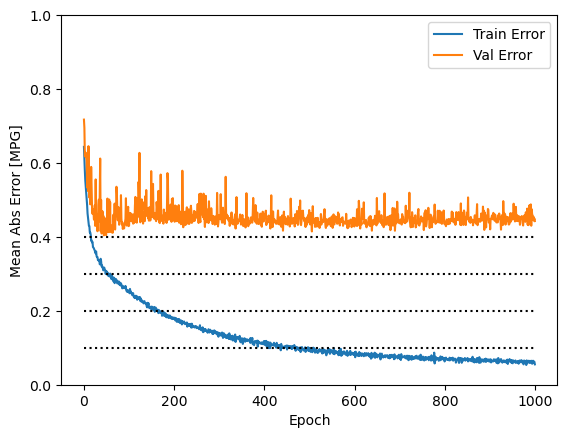

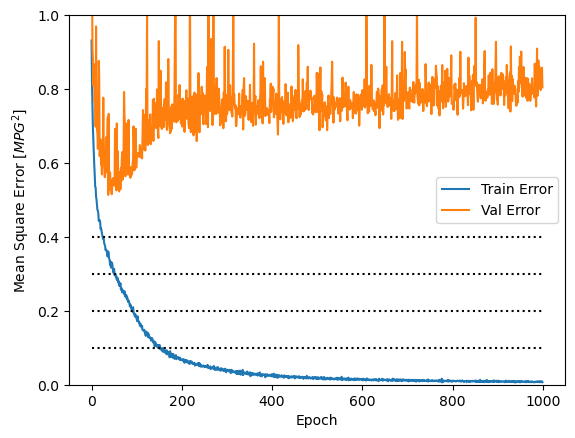

In [60]:
plot_history(history)

In [100]:
#..Build da model ... deep neural network 02  (looks a bit better)
def build_model_02():
    model = keras.Sequential([layers.Dense(64, activation=tf.nn.relu, input_shape=[npar]),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  #optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [101]:
model_02 = build_model_02()
EPOCHS = 10000        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_02.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, 
                    validation_data = [params_eval_norm.T,obs_eval_stan.T], 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

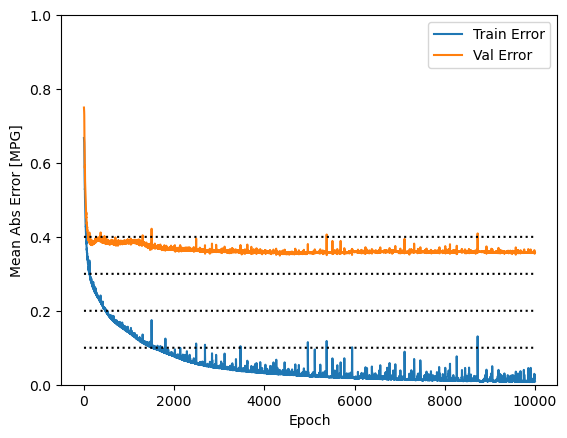

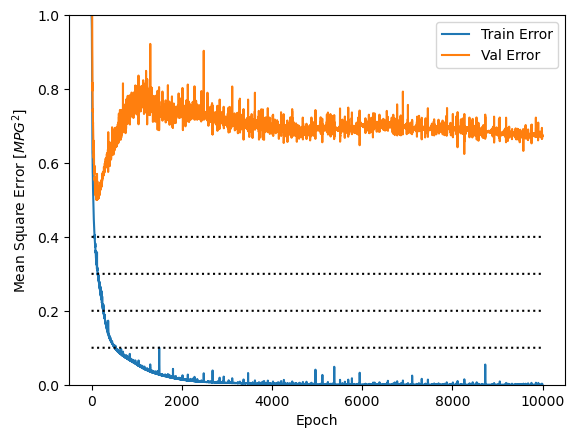

In [102]:
plot_history(history)

In [74]:
#..Build da model ... deep neural network 02  (looks a bit better)
def build_model_03():
    model = keras.Sequential([layers.Dense(64, activation=tf.nn.relu, input_shape=[npar]),
                              layers.Dense(128, kernel_initializer='normal',activation='relu'),
                              layers.Dense(128, kernel_initializer='normal',activation='relu'),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [75]:
model_03 = build_model_03()
EPOCHS = 1000        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_03.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, 
                    validation_data = [params_eval_norm.T,obs_eval_stan.T], 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

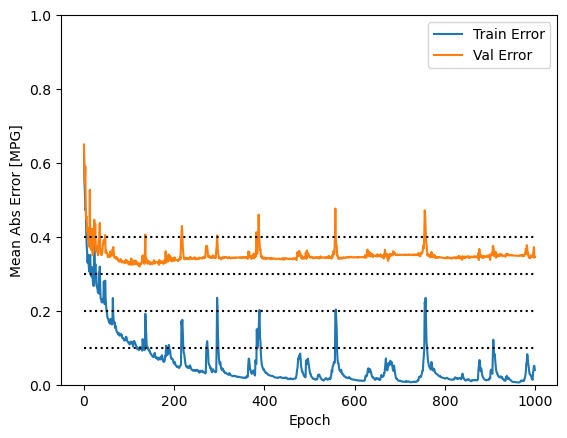

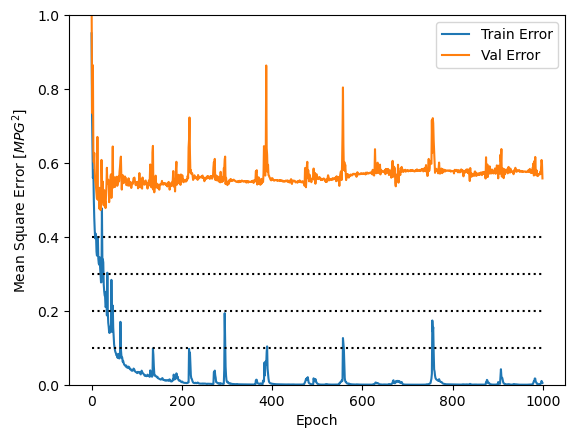

In [76]:
plot_history(history)

In [92]:
#..Build da model ... deep neural network 02  (looks a bit better)
def build_model_04():
    model = keras.Sequential([layers.Dense(32, activation=tf.nn.relu, input_shape=[npar]),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(128, kernel_initializer='normal',activation='relu'),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
    #model.compile(loss='mean_absolute_error',
                  optimizer=optimizer,
                  #optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [93]:
model_04 = build_model_04()
EPOCHS = 10000        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_04.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, 
                    validation_data = [params_eval_norm.T,obs_eval_stan.T], 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

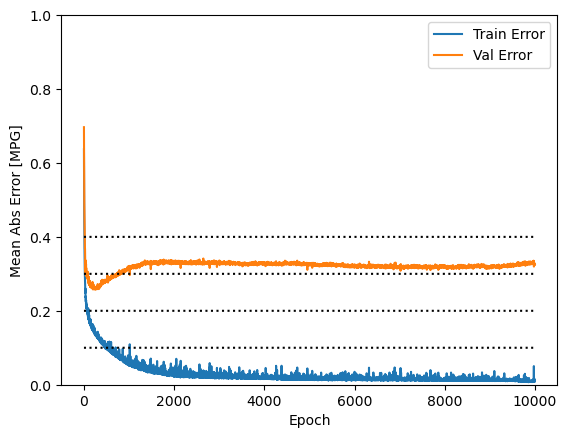

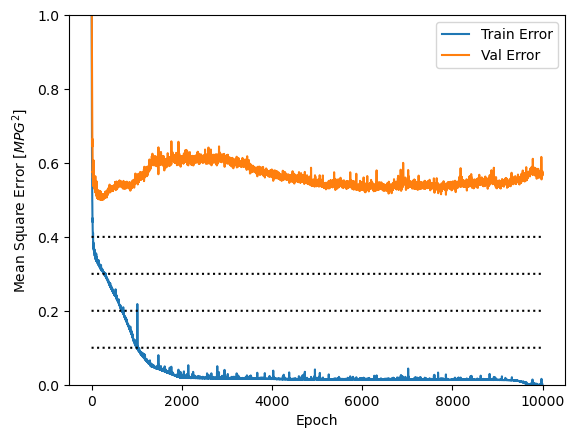

In [91]:
plot_history(history)

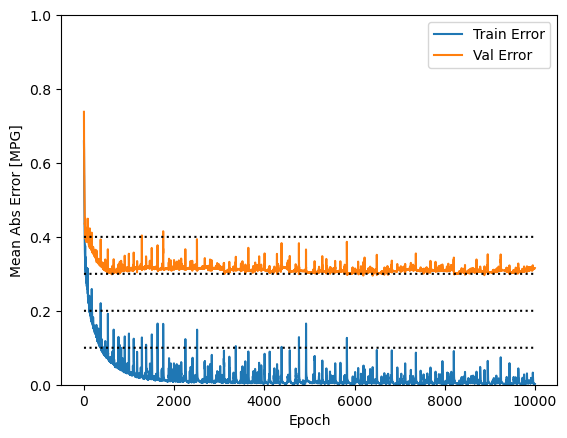

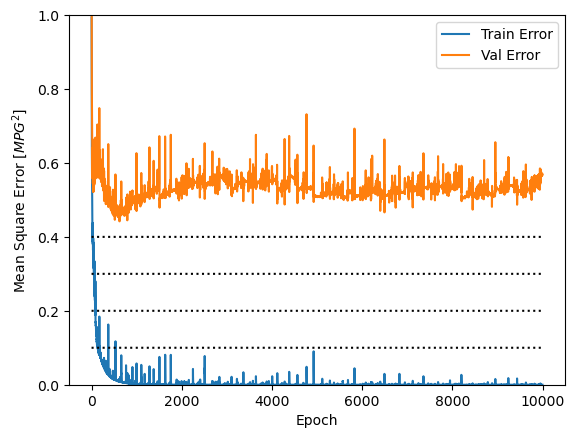

In [94]:
plot_history(history)